# Identifying competitors using dimension reduction and clustering methods

In this project we will test different dimension reduction methods to visualize price dispersion. Price dispersion can imply about market competition, consumer behavior and pricing strategies.

We choose to evaluate competition within the market through two primary aspects:
- Price movement synchronization - the similarity of pricing changes amongst competitors, which may indicate a coordinated or strategic approach to pricing.
- Price level similarity - The similarity of pricing levels amongst competitors, which may indicate a competitive pricing environment.

In [1]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.patches as mpatches
import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap.umap_ as umap

from sklearn.cluster import DBSCAN, OPTICS, Birch
from sklearn.metrics import silhouette_score, davies_bouldin_score

import rpy2.robjects as robjects
from rpy2.robjects import pandas2ri
readRDS = robjects.r['readRDS']

import warnings
warnings.filterwarnings("ignore", category=UserWarning)

In [2]:
# Set the desired inputs
category = 'toilet paper'
stores = range(1001,2450)

In [3]:
# Import the store data
Store_data = pd.read_excel('C:/Users/Documents/Store_data.xlsx')
Store_data = Store_data[['ChainID','ChainName','SubChainID','SubChainName','StoreID','StoreName']]

Subchain_names = pd.read_excel('C:/Users/Documents/SubChainNameEnglish.xlsx')
Store_data = Store_data.merge(Subchain_names, on=['SubChainID','SubChainName'], how='left')
Store_data['SubChainName'] = Store_data['EnglishName']
Store_data = Store_data.drop(columns=['EnglishName'])
Store_data

,ChainID,ChainName,SubChainID,SubChainName,StoreID,StoreName
0,10,דור אלון,10,AM:PM,1001,אבן גבירול (פינת ז'בוטינסקי)
1,10,דור אלון,10,AM:PM,1002,אבן גבירול 14
2,10,דור אלון,10,AM:PM,1003,אלנבי (פינת יהודה הלוי)
3,10,דור אלון,10,AM:PM,1004,בוגרשוב (פינת פינסקר)
4,10,דור אלון,10,AM:PM,1005,בן יהודה (פינת נורדאו)
...,...,...,...,...,...,...
1577,24,קשת טעמים,41,Keshet Te’amim,2578,עכו
1578,15,יינות ביתן,22,Mega Ba’Ir,2579,תל אביב - מנחם בגין
1579,16,שופרסל,28,Shufersal Express,2580,תל אביב מנדלי מוכר ספרים
1580,15,יינות ביתן,22,Mega Ba’Ir,2581,רמת החייל - הברזל


In [ ]:
# Import the price data in one category and convert it to wide data
df = []
error_message = "Error in reading RDS file"
for store in stores:
    try:
        # import the data
        df_store = readRDS('G:/retail data/rds data/data by store/'+category+'/'+str(store)+'.rds')
        df_store = pandas2ri.rpy2py_dataframe(df_store)
    
        # filter the data
        df_store['Date'] = pd.to_datetime(df_store['Date'], utc=True, unit='d').apply(lambda x: x.strftime('%Y-%m-%d'))
        df_store['Date'] = pd.to_datetime(df_store['Date'], errors='coerce')
        df_store = df_store[df_store['Date'].dt.strftime('%Y-%m-%d') >= '2019-03-01']

        df_store['category'] = category

        # create wide data
        wide_df = df_store.groupby(['category','ProductDescription','StoreID','Date'])['FinalPrice'].mean().unstack()

        df.append(wide_df)
    except:
        df_store = None

df = pd.concat(df)

In [5]:
df

Date                                                                     2019-03-01  \
category     ProductDescription                                 StoreID               
toilet paper נייר טואלט בגוון פסטל לילי פיור 32 גלילים          1001           46.9   
             נייר טואלט גליל כפול טאצ' 24 גלילים                1001           41.9   
             נייר טואלט גליל כפול סופט סנו 24 גלילים            1001            NaN   
             נייר טואלט דו שכבתי בגוון פסטל לילי פיור 30 גלילים 1001            NaN   
             נייר טואלט דו שכבתי גליל ארוך פי 3 סנו סופט 12 ... 1001           33.9   
...                                                                             ...   
             נייר טואלט 3 שכבות סופט סילק 32 גלילים             2449            NaN   
             נייר טואלט דו שכבתי סנו אקו 40 גלילים              2449            NaN   
             נייר טואלט דו שכבתי פסטל לילי 30 גלילים            2449            NaN   
             נייר טואלט סופר פרימיום המותג 32 גלילים            2449            NaN   
             נייר טואלט דו שכבתי מולט 30 גלילים                 2449            NaN   

Date                                                                     2019-03-02  \
category     ProductDescription                                 StoreID               
toilet paper נייר טואלט בגוון פסטל לילי פיור 32 גלילים          1001           46.9   
             נייר טואלט גליל כפול טאצ' 24 גלילים                1001           41.9   
             נייר טואלט גליל כפול סופט סנו 24 גלילים            1001            NaN   
             נייר טואלט דו שכבתי בגוון פסטל לילי פיור 30 גלילים 1001            NaN   
             נייר טואלט דו שכבתי גליל ארוך פי 3 סנו סופט 12 ... 1001           33.9   
...                                                                             ...   
             נייר טואלט 3 שכבות סופט סילק 32 גלילים             2449            NaN   
             נייר טואלט דו שכבתי סנו אקו 40 גלילים              2449            NaN   
             נייר טואלט דו שכבתי פסטל לילי 30 גלילים            2449            NaN   
             נייר טואלט סופר פרימיום המותג 32 גלילים            2449            NaN   
             נייר טואלט דו שכבתי מולט 30 גלילים                 2449            NaN   

Date                                                                     2019-03-03  \
category     ProductDescription                                 StoreID               
toilet paper נייר טואלט בגוון פסטל לילי פיור 32 גלילים          1001           46.9   
             נייר טואלט גליל כפול טאצ' 24 גלילים                1001           41.9   
             נייר טואלט גליל כפול סופט סנו 24 גלילים            1001            NaN   
             נייר טואלט דו שכבתי בגוון פסטל לילי פיור 30 גלילים 1001            NaN   
             נייר טואלט דו שכבתי גליל ארוך פי 3 סנו סופט 12 ... 1001           33.9   
...                                                                             ...   
             נייר טואלט 3 שכבות סופט סילק 32 גלילים             2449            NaN   
             נייר טואלט דו שכבתי סנו אקו 40 גלילים              2449            NaN   
             נייר טואלט דו שכבתי פסטל לילי 30 גלילים            2449            NaN   
             נייר טואלט סופר פרימיום המותג 32 גלילים            2449            NaN   
             נייר טואלט דו שכבתי מולט 30 גלילים                 2449            NaN   

Date                                                                     2019-03-04  \
category     ProductDescription                                 StoreID               
toilet paper נייר טואלט בגוון פסטל לילי פיור 32 גלילים          1001           46.9   
             נייר טואלט גליל כפול טאצ' 24 גלילים                1001           41.9   
             נייר טואלט גליל כפול סופט סנו 24 גלילים            1001            NaN   
             נייר טואלט דו שכבתי בגוון פסטל לילי פיור 30 גלילים 1001            NaN   
             נייר טואלט דו שכבתי גליל ארוך פי 3 סנו סופט 12 ... 1001           33.

### Data pre-processing

We decide to filter out observations (products) with more than 25% missing values in the period we are exmining.

In [6]:
# Filter observations with more than 25% nan values
df_filtered = df.dropna(thresh=int(0.75*731), axis=0)
df_filtered

Date                                                                     2019-03-01  \
category     ProductDescription                                 StoreID               
toilet paper נייר טואלט בגוון פסטל לילי פיור 32 גלילים          1001           46.9   
             נייר טואלט דו שכבתי גליל ארוך פי 3 סנו סופט 12 ... 1001           33.9   
             נייר טואלט דו שכבתי לבבות מולט 32 גלילים           1001           37.9   
             נייר טואלט דו שכבתי לילי פיור לבן חוגלה 32 גלילים  1001           47.9   
             נייר טואלט דו שכבתי סופט סילק לבן סנו 32 גלילים    1001           28.9   
...                                                                             ...   
             נייר טואלט לבן קלינקס 9 גלילים                     2412           39.9   
             נייר טואלט מהדורת חורף בניחוח מפנק לילי 32 גלילים  2412           39.9   
             נייר טואלט מולט לבבות חוגלה 40 גלילים              2412           43.9   
             נייר טואלט קלינקס צהוב 9 גלילים                    2412           39.9   
             נייר טואלט תלת שכבתי לבן לילי טריו 32 גלילים       2412           44.9   

Date                                                                     2019-03-02  \
category     ProductDescription                                 StoreID               
toilet paper נייר טואלט בגוון פסטל לילי פיור 32 גלילים          1001           46.9   
             נייר טואלט דו שכבתי גליל ארוך פי 3 סנו סופט 12 ... 1001           33.9   
             נייר טואלט דו שכבתי לבבות מולט 32 גלילים           1001           37.9   
             נייר טואלט דו שכבתי לילי פיור לבן חוגלה 32 גלילים  1001           47.9   
             נייר טואלט דו שכבתי סופט סילק לבן סנו 32 גלילים    1001           28.9   
...                                                                             ...   
             נייר טואלט לבן קלינקס 9 גלילים                     2412           39.9   
             נייר טואלט מהדורת חורף בניחוח מפנק לילי 32 גלילים  2412           39.9   
             נייר טואלט מולט לבבות חוגלה 40 גלילים              2412           43.9   
             נייר טואלט קלינקס צהוב 9 גלילים                    2412           39.9   
             נייר טואלט תלת שכבתי לבן לילי טריו 32 גלילים       2412           44.9   

Date                                                                     2019-03-03  \
category     ProductDescription                                 StoreID               
toilet paper נייר טואלט בגוון פסטל לילי פיור 32 גלילים          1001           46.9   
             נייר טואלט דו שכבתי גליל ארוך פי 3 סנו סופט 12 ... 1001           33.9   
             נייר טואלט דו שכבתי לבבות מולט 32 גלילים           1001           37.9   
             נייר טואלט דו שכבתי לילי פיור לבן חוגלה 32 גלילים  1001           47.9   
             נייר טואלט דו שכבתי סופט סילק לבן סנו 32 גלילים    1001           28.9   
...                                                                             ...   
             נייר טואלט לבן קלינקס 9 גלילים                     2412           39.9   
             נייר טואלט מהדורת חורף בניחוח מפנק לילי 32 גלילים  2412           39.9   
             נייר טואלט מולט לבבות חוגלה 40 גלילים              2412           43.9   
             נייר טואלט קלינקס צהוב 9 גלילים                    2412           39.9   
             נייר טואלט תלת שכבתי לבן לילי טריו 32 גלילים       2412           44.9   

Date                                                                     2019-03-04  \
category     ProductDescription                                 StoreID               
toilet paper נייר טואלט בגוון פסטל לילי פיור 32 גלילים          1001           46.9   
             נייר טואלט דו שכבתי גליל ארוך פי 3 סנו סופט 12 ... 1001           33.9   
             נייר טואלט דו שכבתי לבבות מולט 32 גלילים           1001           37.9   
             נייר טואלט דו שכבתי לילי פיור לבן חוגלה 32 גלילים  1001           47.9   
             נייר טואלט דו שכבתי סופט סילק לבן סנו 32 גלילים    1001           28.

#### Interpolation and imputation

The way we deal with missing data is as following:
- First interpolate linearly the seires
- Then impute with NOCB method
- Finally, impute with LOCB method

In [7]:
# Interpolation - linear
lfill_df = df_filtered.T.interpolate(method='linear').T
# Imputation - first NOCB and then LOCB
nlfill_df = lfill_df.T.fillna(method='bfill').T
lnlfill_df = nlfill_df.T.fillna(method='ffill').T
lnlfill_df

Date                                                                     2019-03-01  \
category     ProductDescription                                 StoreID               
toilet paper נייר טואלט בגוון פסטל לילי פיור 32 גלילים          1001           46.9   
             נייר טואלט דו שכבתי גליל ארוך פי 3 סנו סופט 12 ... 1001           33.9   
             נייר טואלט דו שכבתי לבבות מולט 32 גלילים           1001           37.9   
             נייר טואלט דו שכבתי לילי פיור לבן חוגלה 32 גלילים  1001           47.9   
             נייר טואלט דו שכבתי סופט סילק לבן סנו 32 גלילים    1001           28.9   
...                                                                             ...   
             נייר טואלט לבן קלינקס 9 גלילים                     2412           39.9   
             נייר טואלט מהדורת חורף בניחוח מפנק לילי 32 גלילים  2412           39.9   
             נייר טואלט מולט לבבות חוגלה 40 גלילים              2412           43.9   
             נייר טואלט קלינקס צהוב 9 גלילים                    2412           39.9   
             נייר טואלט תלת שכבתי לבן לילי טריו 32 גלילים       2412           44.9   

Date                                                                     2019-03-02  \
category     ProductDescription                                 StoreID               
toilet paper נייר טואלט בגוון פסטל לילי פיור 32 גלילים          1001           46.9   
             נייר טואלט דו שכבתי גליל ארוך פי 3 סנו סופט 12 ... 1001           33.9   
             נייר טואלט דו שכבתי לבבות מולט 32 גלילים           1001           37.9   
             נייר טואלט דו שכבתי לילי פיור לבן חוגלה 32 גלילים  1001           47.9   
             נייר טואלט דו שכבתי סופט סילק לבן סנו 32 גלילים    1001           28.9   
...                                                                             ...   
             נייר טואלט לבן קלינקס 9 גלילים                     2412           39.9   
             נייר טואלט מהדורת חורף בניחוח מפנק לילי 32 גלילים  2412           39.9   
             נייר טואלט מולט לבבות חוגלה 40 גלילים              2412           43.9   
             נייר טואלט קלינקס צהוב 9 גלילים                    2412           39.9   
             נייר טואלט תלת שכבתי לבן לילי טריו 32 גלילים       2412           44.9   

Date                                                                     2019-03-03  \
category     ProductDescription                                 StoreID               
toilet paper נייר טואלט בגוון פסטל לילי פיור 32 גלילים          1001           46.9   
             נייר טואלט דו שכבתי גליל ארוך פי 3 סנו סופט 12 ... 1001           33.9   
             נייר טואלט דו שכבתי לבבות מולט 32 גלילים           1001           37.9   
             נייר טואלט דו שכבתי לילי פיור לבן חוגלה 32 גלילים  1001           47.9   
             נייר טואלט דו שכבתי סופט סילק לבן סנו 32 גלילים    1001           28.9   
...                                                                             ...   
             נייר טואלט לבן קלינקס 9 גלילים                     2412           39.9   
             נייר טואלט מהדורת חורף בניחוח מפנק לילי 32 גלילים  2412           39.9   
             נייר טואלט מולט לבבות חוגלה 40 גלילים              2412           43.9   
             נייר טואלט קלינקס צהוב 9 גלילים                    2412           39.9   
             נייר טואלט תלת שכבתי לבן לילי טריו 32 גלילים       2412           44.9   

Date                                                                     2019-03-04  \
category     ProductDescription                                 StoreID               
toilet paper נייר טואלט בגוון פסטל לילי פיור 32 גלילים          1001           46.9   
             נייר טואלט דו שכבתי גליל ארוך פי 3 סנו סופט 12 ... 1001           33.9   
             נייר טואלט דו שכבתי לבבות מולט 32 גלילים           1001           37.9   
             נייר טואלט דו שכבתי לילי פיור לבן חוגלה 32 גלילים  1001           47.9   
             נייר טואלט דו שכבתי סופט סילק לבן סנו 32 גלילים    1001           28.

##### Data scaling

In our case all the prices are in the same currency, but we will scale the data to ensure that all features are on a similar scale and to help to PCA to get better results.

As explained earlier we will detect two competition dimensions: price movement and price level. Therefore we will scale the data in two different ways, for each dimension. To demonstrate the concept, we will use a single product as an example. However, the optimal method will be selected based on analysis of a larger dataset.

In [8]:
### choose one item and filter the data
lnlfill_df.reset_index(inplace=True)
most_frequent_value = lnlfill_df['ProductDescription'].mode()[0]
product_df = lnlfill_df[lnlfill_df['ProductDescription'] == most_frequent_value]

# Merge with store data
product_df['StoreID'] = product_df['StoreID'].astype('int64')
product_df = pd.merge(product_df, Store_data, how="left", left_on="StoreID", right_on="StoreID")
product_df.set_index(['ChainID','ChainName','SubChainID','SubChainName','StoreID','StoreName','category','ProductDescription'], inplace=True)
product_df

<ipython-input-8-c4b9388c905c>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  product_df['StoreID'] = product_df['StoreID'].astype('int64')


2019-03-01  \
ChainID ChainName SubChainID SubChainName StoreID StoreName                    category     ProductDescription                                              
10      דור אלון  10         AM:PM        1001    אבן גבירול (פינת ז'בוטינסקי) toilet paper נייר טואלט דו שכבתי לילי פיור לבן חוגלה 32 גלילים        47.9   
                                          1003    אלנבי  (פינת יהודה הלוי)     toilet paper נייר טואלט דו שכבתי לילי פיור לבן חוגלה 32 גלילים        47.9   
                                          1004    בוגרשוב  (פינת פינסקר)       toilet paper נייר טואלט דו שכבתי לילי פיור לבן חוגלה 32 גלילים        47.9   
                                          1005    בן יהודה  (פינת נורדאו)      toilet paper נייר טואלט דו שכבתי לילי פיור לבן חוגלה 32 גלילים        47.9   
                                          1006    בן יהודה  (פינת שלום עליכם)  toilet paper נייר טואלט דו שכבתי לילי פיור לבן חוגלה 32 גלילים        47.9   
...                                                                                                                                                   ...   
16      שופרסל    46         Be           2299    סגולה                        toilet paper נייר טואלט דו שכבתי לילי פיור לבן חוגלה 32 גלילים        39.9   
                                          2300    פלורנטין                     toilet paper נייר טואלט דו שכבתי לילי פיור לבן חוגלה 32 גלילים        39.9   
                                          2305    כרמיאל                       toilet paper נייר טואלט דו שכבתי לילי פיור לבן חוגלה 32 גלילים        37.9   
                                          2307    חשמונאים                     toilet paper נייר טואלט דו שכבתי לילי פיור לבן חוגלה 32 גלילים        39.9   
27      סופר-פארם 44         Super Pharm  2412    באר שבע שאול המלך            toilet paper נייר טואלט דו שכבתי לילי פיור לבן חוגלה 32 גלילים        36.9   

                                                                                                                                               2019-03-02  \
ChainID ChainName SubChainID SubChainName StoreID StoreName                    category     ProductDescription                                              
10      דור אלון  10         AM:PM        1001    אבן גבירול (פינת ז'בוטינסקי) toilet paper נייר טואלט דו שכבתי לילי פיור לבן חוגלה 32 גלילים        47.9   
                                          1003    אלנבי  (פינת יהודה הלוי)     toilet paper נייר טואלט דו שכבתי לילי פיור לבן חוגלה 32 גלילים        47.9   
                                          1004    בוגרשוב  (פינת פינסקר)       toilet paper נייר טואלט דו שכבתי לילי פיור לבן חוגלה 32 גלילים        47.9   
                                          1005    בן יהודה  (פינת נורדאו)      toilet paper נייר טואלט דו שכבתי לילי פיור לבן חוגלה 32 גלילים        47.9   
                                          1006    בן יהודה  (פינת שלום עליכם)  toilet paper נייר טואלט דו שכבתי לילי פיור לבן חוגלה 32 גלילים        47.9   
...                                                                                                                                                   ...   
16      שופרסל    46         Be           2299    סגולה                        toilet paper נייר טואלט דו שכבתי לילי פיור לבן חוגלה 32 גלילים        39.9   
                                          2300    פלורנטין                     toilet paper נייר טואלט דו שכבתי לילי פיור לבן חוגלה 32 גלילים        39.9   
                                          2305    כרמיאל                       toilet paper נייר טואלט דו שכבתי לילי פיור לבן חוגלה 32 גלילים        37.9   
                                          2307    חשמונאים                     toilet paper נייר טואלט דו שכבתי לילי פיור לבן חוגלה 32 גלילים        39.9   
27      סופר-פארם 44         Super Pharm  2412    באר שבע שאול המלך            toilet paper נייר טואלט דו שכבתי לילי פיור לבן חוגלה 32 גלילים        36.9   

                                                           

In [9]:
### Scale the data for price movement
std_scaler = StandardScaler()
price_movement_df = pd.DataFrame(std_scaler.fit_transform(product_df.T.to_numpy()), columns=product_df.T.columns).T
price_movement_df.columns = product_df.columns

### Scale the data for price level
std_scaler = StandardScaler()
price_level_df = pd.DataFrame(std_scaler.fit_transform(product_df.to_numpy()), columns=product_df.columns)
price_level_df = price_level_df.set_index(product_df.index)

## Dimensionality reduction

Now, with our data we can reveal patterns in pricing across different stores.

In [10]:
# Create a dictionary that allocates unique color to unique subschain
subchain_names = product_df.reset_index()['SubChainName'].unique()
color_map = dict(zip(subchain_names, cm.rainbow(np.linspace(0, 1, len(subchain_names)))))
# Create a list of patches (colored rectangles) for the legend
legend_patches = [mpatches.Patch(color=color, label=label) for label, color in color_map.items()]

#### PCA

PCA is an intuitive and a linear technique which means that it help to find patterns in the data that are linear in nature. Therefore, PCA is useful for identifying trends in the data, such as the prices of products over time.

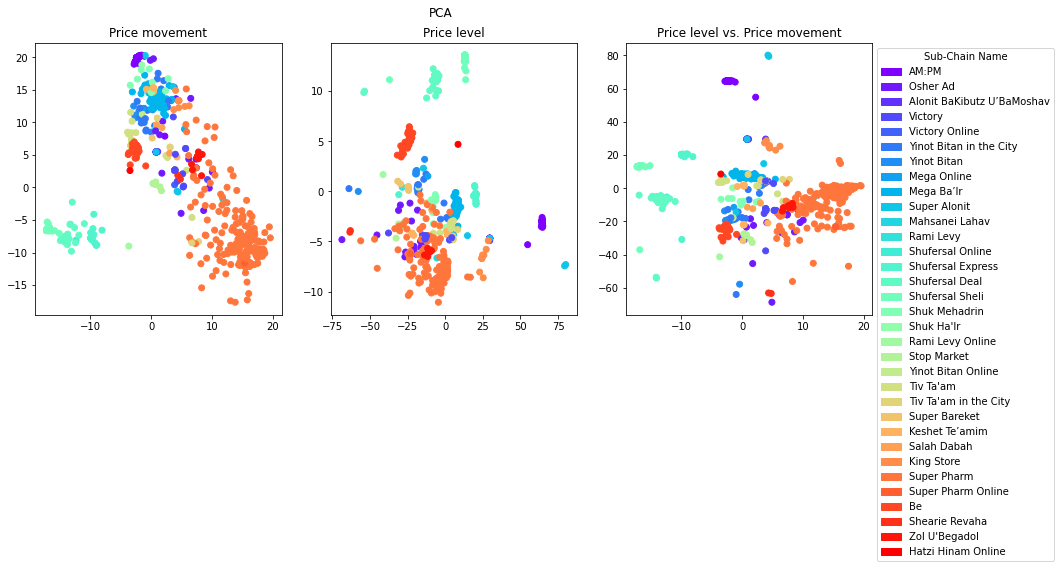

In [11]:
### Price movement ###
pca = PCA()
principalComponents = pca.fit_transform(price_movement_df)
price_movement_principal_df = pd.DataFrame(data = principalComponents)
price_movement_principal_df[['SubChainName', 'StoreName']] = product_df.reset_index()[['SubChainName', 'StoreName']]
price_movement_principal_pca = price_movement_principal_df.copy()

### Price level ###
pca = PCA()
principalComponents = pca.fit_transform(price_level_df)
price_level_principal_df = pd.DataFrame(data = principalComponents)
price_level_principal_df[['SubChainName', 'StoreName']] = product_df.reset_index()[['SubChainName', 'StoreName']]
price_level_principal_pca = price_level_principal_df.copy()

### Combination - price level and Price movement ###
combined_components_df = pd.concat([price_movement_principal_df.iloc[:, 0],price_level_principal_df.iloc[:, 0]], axis=1)
combined_components_df.columns = ['PrincipalPriceMovement','PrincipalPricelevel']
combined_components_df[['SubChainName', 'StoreName']] = product_df.reset_index()[['SubChainName', 'StoreName']]


## plot the principal components
fig, ax = plt.subplots(1, 3, figsize=(15,5))
# Subplot 1
ax[0].scatter(price_movement_principal_df.loc[:,0], price_movement_principal_df.loc[:,1], c=price_movement_principal_df['SubChainName'].map(color_map))
ax[0].set_title('Price movement')
# Subplot 2
ax[1].scatter(price_level_principal_df.loc[:,0], price_level_principal_df.loc[:,1], c=price_level_principal_df['SubChainName'].map(color_map))
ax[1].set_title('Price level')
# Subplot 3
ax[2].scatter(combined_components_df['PrincipalPriceMovement'], combined_components_df['PrincipalPricelevel'], c=combined_components_df['SubChainName'].map(color_map))
ax[2].set_title('Price level vs. Price movement')

plt.legend(loc='best', handles=legend_patches, bbox_to_anchor=(1, 1), title='Sub-Chain Name')
fig.suptitle('PCA')
plt.show()

#### t-SNE

t-SNE is a non-linear technique that can be useful to identify outliers in the data.

C:\Users\Israel\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\Israel\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
C:\Users\Israel\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\Israel\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


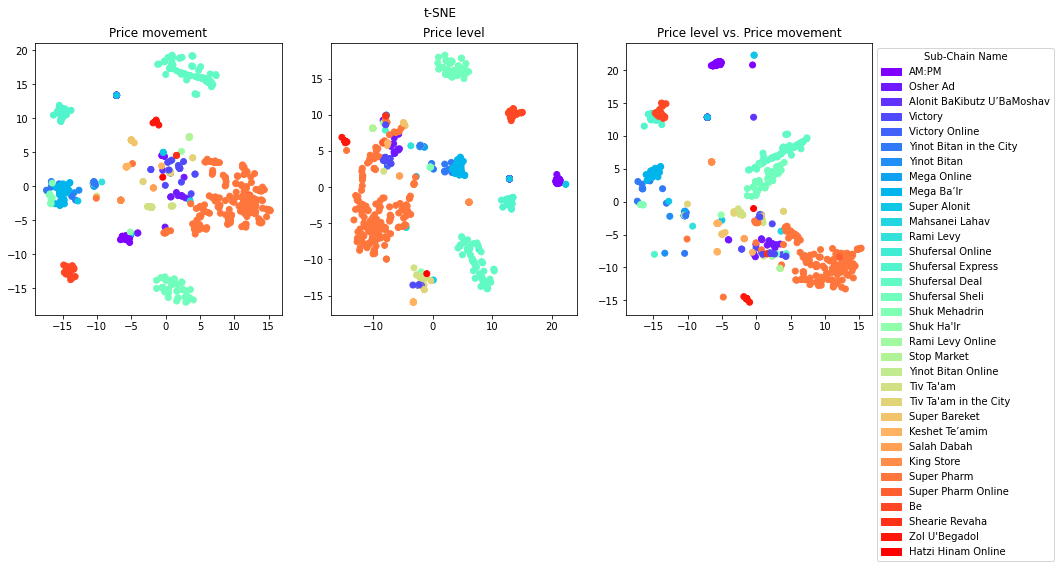

In [12]:
### Price movement ###
tsne = TSNE(n_components=2, perplexity=40, n_iter=300,  method='exact')
X_embedded = tsne.fit_transform(price_movement_df)
price_movement_principal_df = pd.DataFrame(data = X_embedded)
price_movement_principal_df[['SubChainName', 'StoreName']] = product_df.reset_index()[['SubChainName', 'StoreName']]
price_movement_principal_tsne = price_movement_principal_df.copy()

### Price level ###
tsne = TSNE(n_components=2, perplexity=40, n_iter=300,  method='exact')
X_embedded = tsne.fit_transform(price_level_df)
price_level_principal_df = pd.DataFrame(data = X_embedded)
price_level_principal_df[['SubChainName', 'StoreName']] = product_df.reset_index()[['SubChainName', 'StoreName']]
price_level_principal_tsne = price_level_principal_df.copy()

### Combination - price level and Price movement ###
combined_components_df = pd.concat([price_movement_principal_df.iloc[:, 0],price_level_principal_df.iloc[:, 0]], axis=1)
combined_components_df.columns = ['PrincipalPriceMovement','PrincipalPricelevel']
combined_components_df[['SubChainName', 'StoreName']] = product_df.reset_index()[['SubChainName', 'StoreName']]


## plot the principal components
fig, ax = plt.subplots(1, 3, figsize=(15,5))
# Subplot 1
ax[0].scatter(price_movement_principal_df.loc[:,0], price_movement_principal_df.loc[:,1], c=price_movement_principal_df['SubChainName'].map(color_map))
ax[0].set_title('Price movement')
# Subplot 2
ax[1].scatter(price_level_principal_df.loc[:,0], price_level_principal_df.loc[:,1], c=price_level_principal_df['SubChainName'].map(color_map))
ax[1].set_title('Price level')
# Subplot 3
ax[2].scatter(combined_components_df['PrincipalPriceMovement'], combined_components_df['PrincipalPricelevel'], c=combined_components_df['SubChainName'].map(color_map))
ax[2].set_title('Price level vs. Price movement')

plt.legend(loc='best', handles=legend_patches, bbox_to_anchor=(1, 1), title='Sub-Chain Name')
fig.suptitle('t-SNE')
plt.show()

#### UMAP

UMAP can fit better when the data sets have non-linear structure and can preserve better the local structure of the data. Thus, it helps to ensure that the relationships and patterns that exist in high-dimensional space are not lost during the dimensionality reduction process.

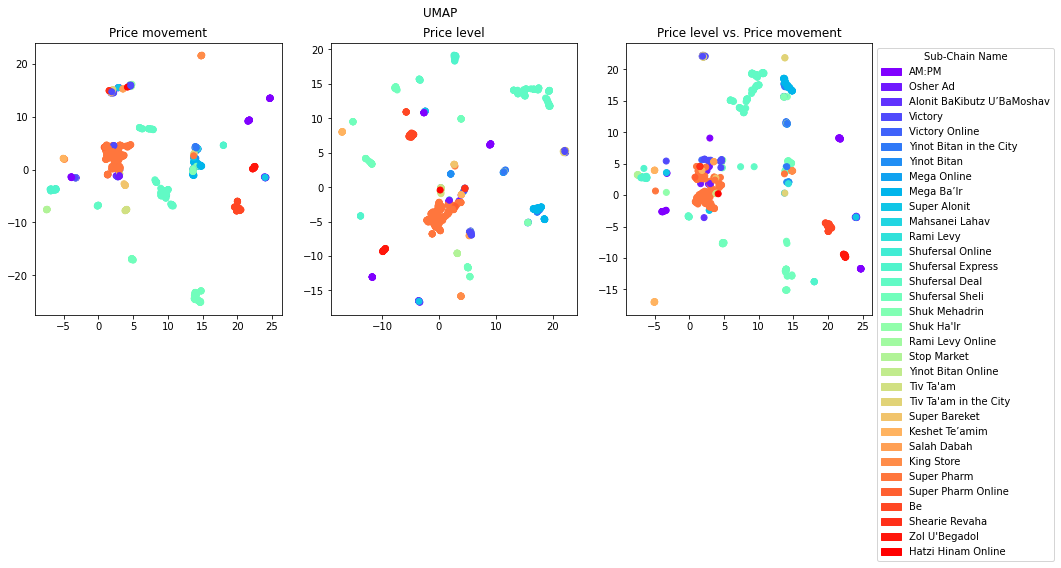

In [21]:
### Price movement ###
umap_obj = umap.UMAP(n_neighbors=5, n_components=2)
X_umap = umap_obj.fit_transform(price_movement_df)
price_movement_principal_df = pd.DataFrame(data = X_umap)
price_movement_principal_df[['SubChainName', 'StoreName']] = product_df.reset_index()[['SubChainName', 'StoreName']]
price_movement_principal_umap = price_movement_principal_df.copy()

### Price level ###
umap_obj = umap.UMAP(n_neighbors=5, n_components=2)
X_umap = umap_obj.fit_transform(price_level_df)
price_level_principal_df = pd.DataFrame(data = X_umap)
price_level_principal_df[['SubChainName', 'StoreName']] = product_df.reset_index()[['SubChainName', 'StoreName']]
price_level_principal_umap = price_level_principal_df.copy()

### Combination - price level and Price movement ###
combined_components_df = pd.concat([price_movement_principal_df.iloc[:, 0],price_level_principal_df.iloc[:, 0]], axis=1)
combined_components_df.columns = ['PrincipalPriceMovement','PrincipalPricelevel']
combined_components_df[['SubChainName', 'StoreName']] = product_df.reset_index()[['SubChainName', 'StoreName']]


## plot the principal components
fig, ax = plt.subplots(1, 3, figsize=(15,5))
# Subplot 1
ax[0].scatter(price_movement_principal_df.loc[:,0], price_movement_principal_df.loc[:,1], c=price_movement_principal_df['SubChainName'].map(color_map))
ax[0].set_title('Price movement')
# Subplot 2
ax[1].scatter(price_level_principal_df.loc[:,0], price_level_principal_df.loc[:,1], c=price_level_principal_df['SubChainName'].map(color_map))
ax[1].set_title('Price level')
# Subplot 3
ax[2].scatter(combined_components_df['PrincipalPriceMovement'], combined_components_df['PrincipalPricelevel'], c=combined_components_df['SubChainName'].map(color_map))
ax[2].set_title('Price level vs. Price movement')

plt.legend(loc='best', handles=legend_patches, bbox_to_anchor=(1, 1), title='Sub-Chain Name')
fig.suptitle('UMAP')
plt.show()

The visualizations produced by the methods discussed above can indicate similarities or differences in pricing strategies among stores.
- Price movement plot - suggests that certain stores have similar patterns of price changes over time.
- Price level plot - indicates that certain stores tend to maintain similar prices across a given period of time.
- Price level and price movement store - implies similaries in pricing strategies of stores that adopt similar price strategy in the price level and the price movement.

As a store manager, I will use the visualizations from the dimension reduction methods to identify stores that have similar pricing strategies. This will help me in building my own store's pricing strategy. However, for a pricing department in a supermarket chain, a more comprehensive and automated process is required to analyze the pricing strategies of multiple stores, i.e., with clustering.

Also, to dicide which dimension reduction method we should use, we will explore different clustering methods and its quality. The clusters will also help to define 'competition clusters'.

## Cluster analysis

We will use the reduced data to perform clustering. To perform clustering we will use for each dimension reduction method the top 2 components we found for price movement and the top 2 components we found for price level. Clustering will help us to determine how well the clustering method has separated the different stores based on pricing strategies.

In [22]:
# Data preparation for clustering 

# PCA
pca_components_df = pd.concat([price_movement_principal_pca.iloc[:, 0:2],price_level_principal_pca.iloc[:, 0:2]], axis=1)
pca_components_df.columns = ['P_M_1','P_M_2','P_L_1','P_L_2']
pca_components_df[['SubChainName', 'StoreName']] = product_df.reset_index()[['SubChainName', 'StoreName']]
pca_components_df.set_index(['SubChainName', 'StoreName'], inplace=True)

# t-SNE
tsne_components_df = pd.concat([price_movement_principal_tsne.iloc[:, 0:2],price_level_principal_tsne.iloc[:, 0:2]], axis=1)
tsne_components_df.columns = ['P_M_1','P_M_2','P_L_1','P_L_2']
tsne_components_df[['SubChainName', 'StoreName']] = product_df.reset_index()[['SubChainName', 'StoreName']]
tsne_components_df.set_index(['SubChainName', 'StoreName'], inplace=True)

# UMAP
umap_components_df = pd.concat([price_movement_principal_umap.iloc[:, 0:2],price_level_principal_umap.iloc[:, 0:2]], axis=1)
umap_components_df.columns = ['P_M_1','P_M_2','P_L_1','P_L_2']
umap_components_df[['SubChainName', 'StoreName']] = product_df.reset_index()[['SubChainName', 'StoreName']]
umap_components_df.set_index(['SubChainName', 'StoreName'], inplace=True)

# log table
models_evaluation = pd.DataFrame(columns=["clustering_model", "dimension_reduction", "cluster_number","silhouette_score", "davies_bouldin_score"])

#### DBSCAN

DBSCAN groups data points that are within a certain distance of each other and separates data points that are not within this distance.

In [23]:
### PCA ###
# Define and fit the DBSCAN model
dbscan = DBSCAN(eps=0.5, min_samples=5)
dbscan.fit(pca_components_df)
# Get the cluster labels
pca_dbscan_labels = dbscan.labels_
# Number of clusters
cluster_num = len(set(pca_dbscan_labels)) - (1 if -1 in pca_dbscan_labels else 0)

models_evaluation.loc[len(models_evaluation)] = ['DBSCAN','PCA',cluster_num,silhouette_score(pca_components_df, pca_dbscan_labels),davies_bouldin_score(pca_components_df, pca_dbscan_labels)]

### t-SNE ###
# Define and fit the DBSCAN model
dbscan = DBSCAN(eps=0.5, min_samples=5)
dbscan.fit(tsne_components_df)
# Get the cluster labels
tsne_dbscan_labels = dbscan.labels_
# Number of clusters
cluster_num = len(set(tsne_dbscan_labels)) - (1 if -1 in tsne_dbscan_labels else 0)

models_evaluation.loc[len(models_evaluation)] = ['DBSCAN','t-SNE',cluster_num,silhouette_score(tsne_components_df, tsne_dbscan_labels),davies_bouldin_score(tsne_components_df, tsne_dbscan_labels)]

### UMAP ###
# Define and fit the DBSCAN model
dbscan = DBSCAN(eps=0.5, min_samples=5)
dbscan.fit(umap_components_df)
# Get the cluster labels
umap_dbscan_labels = dbscan.labels_
# Number of clusters
cluster_num = len(set(umap_dbscan_labels)) - (1 if -1 in umap_dbscan_labels else 0)

models_evaluation.loc[len(models_evaluation)] = ['DBSCAN','UMAP',cluster_num,silhouette_score(umap_components_df, umap_dbscan_labels),davies_bouldin_score(umap_components_df, umap_dbscan_labels)]


#### OPTICS

OPTICS generates a hierarchy of clusters. It is considered more robust and can handle clusters with varying densities.

In [24]:
### PCA ###
# Define and fit the OPTICS model
optics = OPTICS(min_samples=5, metric='minkowski', min_cluster_size=0.02)
optics.fit(pca_components_df)
# Get the cluster labels
pca_optics_labels = optics.labels_
# Number of clusters
cluster_num = len(set(pca_optics_labels)) - (1 if -1 in pca_optics_labels else 0)

models_evaluation.loc[len(models_evaluation)] = ['OPTICS','PCA',cluster_num,silhouette_score(pca_components_df, pca_optics_labels),davies_bouldin_score(pca_components_df, pca_optics_labels)]

### t-SNE ###
# Define and fit the OPTICS model
optics = OPTICS(min_samples=5, metric='minkowski', min_cluster_size=0.02)
optics.fit(tsne_components_df)
# Get the cluster labels
tsne_optics_labels = optics.labels_
# Number of clusters
cluster_num = len(set(tsne_optics_labels)) - (1 if -1 in tsne_optics_labels else 0)

models_evaluation.loc[len(models_evaluation)] = ['OPTICS','t-SNE',cluster_num,silhouette_score(tsne_components_df, tsne_optics_labels),davies_bouldin_score(tsne_components_df, tsne_optics_labels)]

### UMAP ###
# Define and fit the OPTICS model
optics = OPTICS(min_samples=5, metric='minkowski', min_cluster_size=0.02)
optics.fit(umap_components_df)
# Get the cluster labels
umap_optics_labels = optics.labels_
# Number of clusters
cluster_num = len(set(umap_optics_labels)) - (1 if -1 in umap_optics_labels else 0)

models_evaluation.loc[len(models_evaluation)] = ['OPTICS','UMAP',cluster_num,silhouette_score(umap_components_df, umap_optics_labels),davies_bouldin_score(umap_components_df, umap_optics_labels)]


C:\Users\Israel\anaconda3\lib\site-packages\sklearn\cluster\_optics.py:903: RuntimeWarning: divide by zero encountered in true_divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


#### BIRCH

BIRCH uses a tree-based structure and handles large datasets efficiently.

In [25]:
### PCA ###
# Define and fit the BIRCH model
birch = Birch(threshold=9, n_clusters=None)
birch.fit(pca_components_df)
# Get the cluster labels
pca_birch_labels = birch.labels_
# Number of clusters
cluster_num = len(set(pca_birch_labels)) - (1 if -1 in pca_birch_labels else 0)

models_evaluation.loc[len(models_evaluation)] = ['BIRCH','PCA',cluster_num,silhouette_score(pca_components_df, pca_birch_labels),davies_bouldin_score(pca_components_df, pca_birch_labels)]

### t-SNE ###
# Define and fit the BIRCH model
birch = Birch(threshold=9, n_clusters=None)
birch.fit(tsne_components_df)
# Get the cluster labels
tsne_birch_labels = birch.labels_
# Number of clusters
cluster_num = len(set(tsne_birch_labels)) - (1 if -1 in tsne_birch_labels else 0)

models_evaluation.loc[len(models_evaluation)] = ['BIRCH','t-SNE',cluster_num,silhouette_score(tsne_components_df, tsne_birch_labels),davies_bouldin_score(tsne_components_df, tsne_birch_labels)]

### UMAP ###
# Define and fit the BIRCH model
birch = Birch(threshold=9, n_clusters=None)
birch.fit(umap_components_df)
# Get the cluster labels
umap_birch_labels = birch.labels_
# Number of clusters
cluster_num = len(set(umap_birch_labels)) - (1 if -1 in umap_birch_labels else 0)

models_evaluation.loc[len(models_evaluation)] = ['BIRCH','UMAP',cluster_num,silhouette_score(umap_components_df, umap_birch_labels),davies_bouldin_score(umap_components_df, umap_birch_labels)]


#### Model comparison

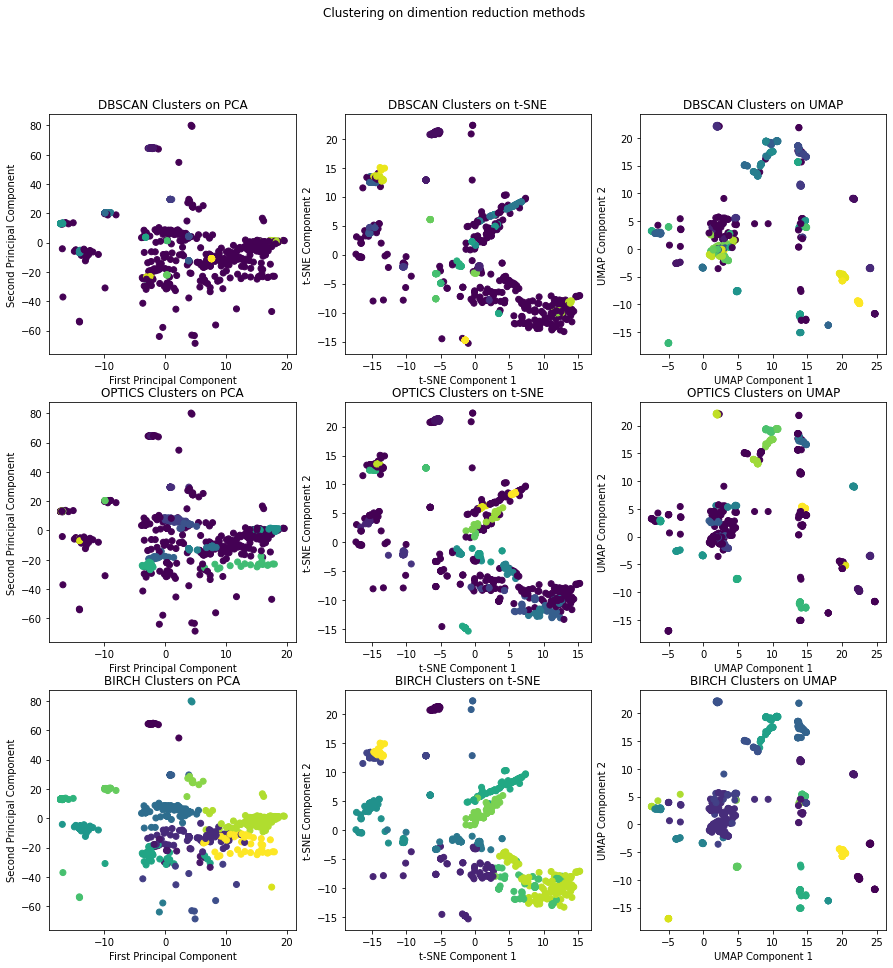

In [26]:
fig, axs = plt.subplots(3, 3, figsize=(15, 15))

# DBSCAN on PCA
axs[0, 0].scatter(pca_components_df['P_M_1'], pca_components_df['P_L_1'], c=pca_dbscan_labels)
axs[0, 0].set_xlabel('First Principal Component')
axs[0, 0].set_ylabel('Second Principal Component')
axs[0, 0].set_title('DBSCAN Clusters on PCA')

# DBSCAN on t-SNE
axs[0, 1].scatter(tsne_components_df['P_M_1'], tsne_components_df['P_L_1'], c=tsne_dbscan_labels)
axs[0, 1].set_xlabel('t-SNE Component 1')
axs[0, 1].set_ylabel('t-SNE Component 2')
axs[0, 1].set_title('DBSCAN Clusters on t-SNE')

# DBSCAN on UMAP
axs[0, 2].scatter(umap_components_df['P_M_1'], umap_components_df['P_L_1'], c=umap_dbscan_labels)
axs[0, 2].set_xlabel('UMAP Component 1')
axs[0, 2].set_ylabel('UMAP Component 2')
axs[0, 2].set_title('DBSCAN Clusters on UMAP')

# OPTICS on PCA
axs[1, 0].scatter(pca_components_df['P_M_1'], pca_components_df['P_L_1'], c=pca_optics_labels)
axs[1, 0].set_xlabel('First Principal Component')
axs[1, 0].set_ylabel('Second Principal Component')
axs[1, 0].set_title('OPTICS Clusters on PCA')

# OPTICS on t-SNE
axs[1, 1].scatter(tsne_components_df['P_M_1'], tsne_components_df['P_L_1'], c=tsne_optics_labels)
axs[1, 1].set_xlabel('t-SNE Component 1')
axs[1, 1].set_ylabel('t-SNE Component 2')
axs[1, 1].set_title('OPTICS Clusters on t-SNE')

# OPTICS on UMAP
axs[1, 2].scatter(umap_components_df['P_M_1'], umap_components_df['P_L_1'], c=umap_optics_labels)
axs[1, 2].set_xlabel('UMAP Component 1')
axs[1, 2].set_ylabel('UMAP Component 2')
axs[1, 2].set_title('OPTICS Clusters on UMAP')

# BIRCH on PCA
axs[2, 0].scatter(pca_components_df['P_M_1'], pca_components_df['P_L_1'], c=pca_birch_labels)
axs[2, 0].set_xlabel('First Principal Component')
axs[2, 0].set_ylabel('Second Principal Component')
axs[2, 0].set_title('BIRCH Clusters on PCA')

# BIRCH on t-SNE
axs[2, 1].scatter(tsne_components_df['P_M_1'], tsne_components_df['P_L_1'], c=tsne_birch_labels)
axs[2, 1].set_xlabel('t-SNE Component 1')
axs[2, 1].set_ylabel('t-SNE Component 2')
axs[2, 1].set_title('BIRCH Clusters on t-SNE')

# BIRCH on UMAP
axs[2, 2].scatter(umap_components_df['P_M_1'], umap_components_df['P_L_1'], c=umap_birch_labels)
axs[2, 2].set_xlabel('UMAP Component 1')
axs[2, 2].set_ylabel('UMAP Component 2')
axs[2, 2].set_title('BIRCH Clusters on UMAP')

fig.suptitle('Clustering on dimention reduction methods')
plt.show()

##### Silhouette coefficient

The silhouette score measures how similar an object is to its own cluster compared to other clusters. High silhouette score means that the stores within a cluster have similar price patterns and are well separated from stores in other clusters.

In [27]:
# Present scores of all the models
models_evaluation.sort_values(by="silhouette_score",ascending=False)

,clustering_model,dimension_reduction,cluster_number,silhouette_score,davies_bouldin_score
8,BIRCH,UMAP,17,0.668678,0.486516
6,BIRCH,PCA,18,0.659558,0.547082
2,DBSCAN,UMAP,52,0.646510,1.171778
7,BIRCH,t-SNE,11,0.605187,0.661417
5,OPTICS,UMAP,21,0.131165,1.042171
1,DBSCAN,t-SNE,30,0.110434,0.987817
0,DBSCAN,PCA,17,0.082208,1.256502
4,OPTICS,t-SNE,20,0.060650,1.148425
3,OPTICS,PCA,16,-0.006100,1.415116


##### Davies-Bbouldin index

The Davies-Bouldin index measures the similarity between each cluster and its most similar cluster, with a lower score indicating better clustering. DBI can help us to evaluate how well the clustering methods separate similar prices from dissimilar prices.

In [28]:
# Present scores of all the models
models_evaluation.sort_values(by="davies_bouldin_score",ascending=True)

,clustering_model,dimension_reduction,cluster_number,silhouette_score,davies_bouldin_score
8,BIRCH,UMAP,17,0.668678,0.486516
6,BIRCH,PCA,18,0.659558,0.547082
7,BIRCH,t-SNE,11,0.605187,0.661417
1,DBSCAN,t-SNE,30,0.110434,0.987817
5,OPTICS,UMAP,21,0.131165,1.042171
4,OPTICS,t-SNE,20,0.060650,1.148425
2,DBSCAN,UMAP,52,0.646510,1.171778
0,DBSCAN,PCA,17,0.082208,1.256502
3,OPTICS,PCA,16,-0.006100,1.415116


By analyzing the visualizations and the evaluation metrics we employed, we see that with UMAP technique, the points are too closely grouped together and not spread out, and it can be difficult to identify distinct clusters and distinguish between different groups of competitors. This can make it harder to effectively implement a market-based pricing strategy for each store. PCA and t-SNE make better separation.

We can see that the BIRCH method, when paired with the PCA technique, effectively helps to identify distinct clusters within the data. This means that we can clearly define competitor clusters for each store, enabling us to adopt more specific, market-based pricing strategies for each store.